In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.signal import argrelextrema
from collections import deque

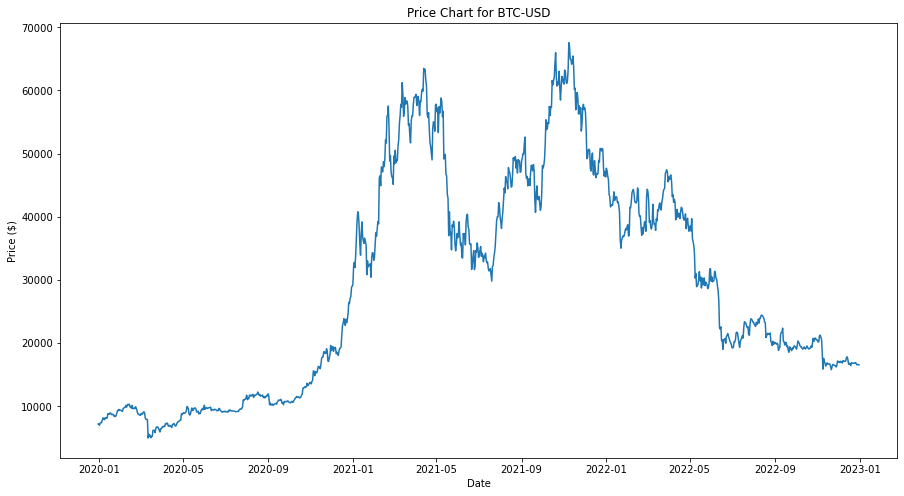

In [61]:
ticker = 'BTC-USD'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start='2020-01-01', end='2023-01-01')

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
plt.title(f'Price Chart for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

We have local maxima and minima - points that are higher or lower than either of the points immediately to the left and right - scattered throughout the chart.

Clearly the peak - or the global maximum over this range - occurs on April 26th when the price closes at $9.80. But would you count the prices on April 5th or April 15th? They are local maxima, but does that make them peaks to mark a divergence? If not, why not? And when would you know?

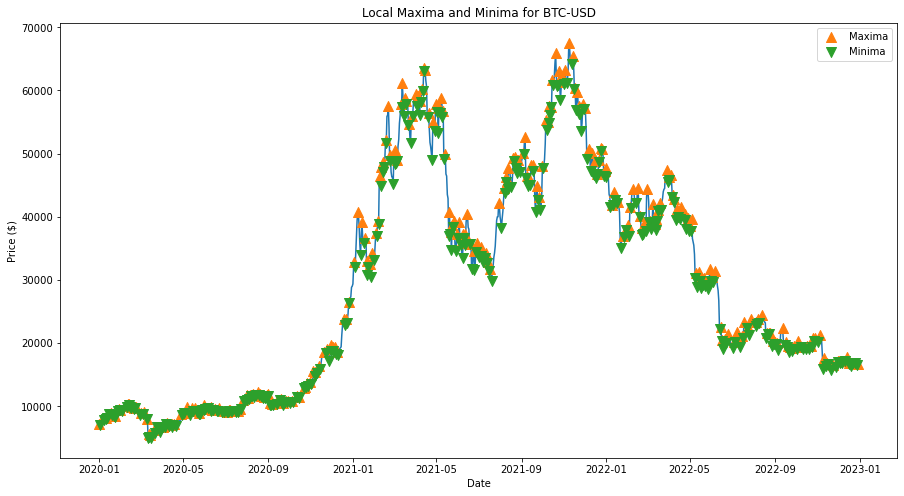

In [62]:
data['local_max'] = data['Close'][
  (data['Close'].shift(1) < data['Close']) &
  (data['Close'].shift(-1) < data['Close'])]

data['local_min'] = data['Close'][
  (data['Close'].shift(1) > data['Close']) &
  (data['Close'].shift(-1) > data['Close'])]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.index, data['local_max'], s=100,
  label='Maxima', marker='^', c=colors[1])
plt.scatter(data.index, data['local_min'], s=100,
  label='Minima', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima for {ticker}')
plt.legend()
plt.show()

# Coding a Convergence/Divergence Indicator

For our purposes, we can use the argrelextrema function from SciPy's signal processing library.

This function will give us the max and min values from a time series. We simply need to pass our data, tell it whether we're looking for maxima or minima values, and then indicate how many data points to either side we're going to look. As shown above, we don't necessarily want to get every local max/min, instead we can look in wider areas to pull out peaks for our divergence indicator.

Take a look at the example below where we wait for 5 data points (order argument) to make our selection.

In [63]:
from scipy.signal import argrelextrema

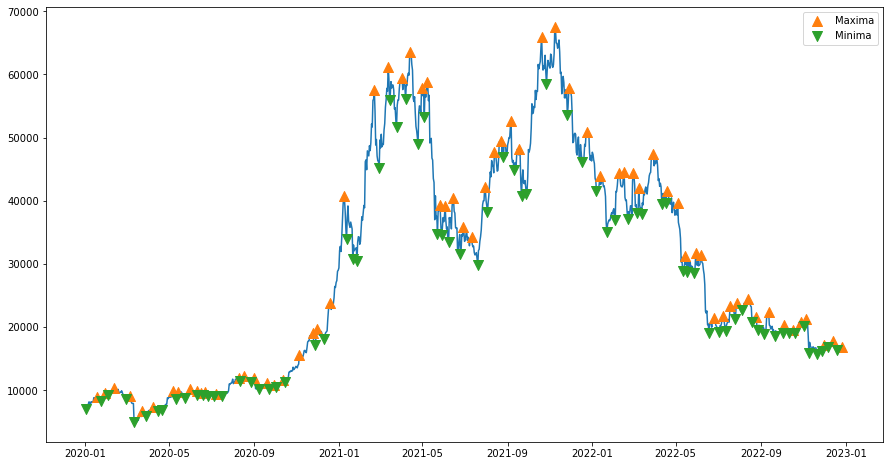

In [64]:
max_idx = argrelextrema(data['Close'].values, np.greater, order=5)[0]
min_idx = argrelextrema(data['Close'].values, np.less, order=5)[0]
plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['Close'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['Close'],
  label='Minima', s=100, color=colors[2], marker='v')

plt.legend()
plt.show()

# Get Consecutive Peaks

Our next step is going to look for consecutive peaks or troughs so we can get "higher highs", "lower lows", "lower highs", or "higher lows". Ultimately we'll have four different cases to look for which will all follow very similar logic. Right now, let's just look cases where there are at least two consecutive "higher highs."

To do this, we're going to have to loop over our indices and check the values against the previous result. If the new peak is greater than the previous peak, we can append it to a list and move on, otherwise we start over with this new peak and look at the next one.

In [65]:
from collections import deque
# Get K consecutive higher peaks
K = 2
high_idx = argrelextrema(data['Close'].values, np.greater, order=5)[0]
highs = data.iloc[high_idx]['Close']

extrema = []
ex_deque = deque(maxlen=K)
for i, idx in enumerate(high_idx):
  if i == 0:
    ex_deque.append(idx)
    continue
  if highs[i] < highs[i-1]:
    ex_deque.clear()

  ex_deque.append(idx)
  if len(ex_deque) == K:
    # K-consecutive higher highs found
    extrema.append(ex_deque.copy())
    
print(extrema)

[deque([18, 30], maxlen=2), deque([30, 43], maxlen=2), deque([84, 99], maxlen=2), deque([99, 128], maxlen=2), deque([135, 153], maxlen=2), deque([168, 174], maxlen=2), deque([190, 223], maxlen=2), deque([223, 230], maxlen=2), deque([273, 286], maxlen=2), deque([286, 310], maxlen=2), deque([310, 329], maxlen=2), deque([329, 335], maxlen=2), deque([335, 354], maxlen=2), deque([354, 374], maxlen=2), deque([374, 418], maxlen=2), deque([418, 438], maxlen=2), deque([458, 469], maxlen=2), deque([487, 494], maxlen=2), deque([520, 532], maxlen=2), deque([558, 577], maxlen=2), deque([577, 591], maxlen=2), deque([591, 601], maxlen=2), deque([601, 615], maxlen=2), deque([627, 659], maxlen=2), deque([659, 678], maxlen=2), deque([743, 771], maxlen=2), deque([771, 777], maxlen=2), deque([799, 819], maxlen=2), deque([866, 882], maxlen=2), deque([907, 920], maxlen=2), deque([920, 931], maxlen=2), deque([931, 940], maxlen=2), deque([940, 956], maxlen=2), deque([968, 986], maxlen=2), deque([1021, 1033], 

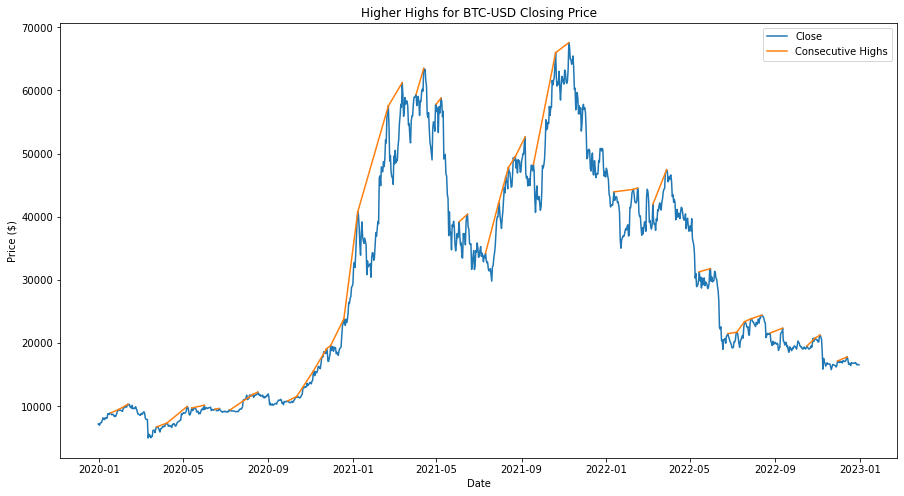

In [66]:
close = data['Close'].values
dates = data.index

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Higher Highs for {ticker} Closing Price')
plt.legend(['Close', 'Consecutive Highs'])
plt.show()

We've pulled out our consecutive highs, so now let's put some functions together to get lower lows, lower highs, and higher lows.



In [67]:
def getHigherLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be higher.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] < lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be lower.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] > highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getHigherHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be higher.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=5)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] < highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be lower.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] > lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

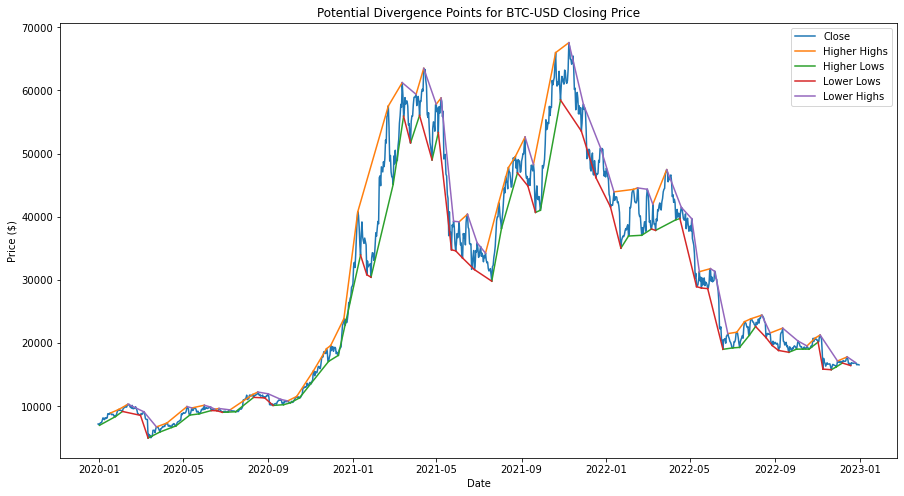

In [68]:
from matplotlib.lines import Line2D

close = data['Close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color=colors[4], label='Lower Highs')
]
plt.legend(handles=legend_elements)
plt.show()

Now we have the functions to identify higher highs and so forth, to mark out potential divergences in price and our indicators. Looking at the plot, everything looks fine except for the Higher Lows line, which seems to skip over a few low points that are indeed higher than the starting point and lower than the ending point. What's going on?

Thankfully, there's no bug. What's happening is that these local minima don't fit our precise rules.

For the argrelextrema, we provide an argument called order which looks that many points to the left and right to find a min or max. In our case, we set this to 5 and it just so happens that a number of these minima are 5 points apart from the last one, meaning they're excluded because they don't satisfy this criteria (change order to 3 or 4 in the code above and see how the plot changes).

Another thing to keep in mind, when we're running a vectorized backtest, we need to wait order-number of periods before we can confirm a higher low, or whatever it is we're looking for to avoid lookahead bias.

We can plot our confirmations to illustrate this delay:

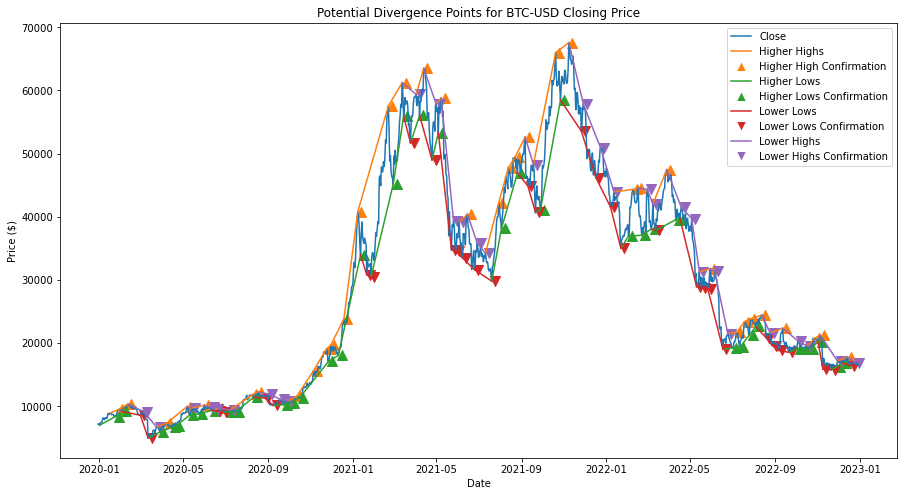

In [69]:
from datetime import timedelta

close = data['Close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]

_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[1], marker='^', s=100) for i in hh]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[2], marker='^', s=100) for i in hl]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], 
    c=colors[3], marker='v', s=100) for i in ll]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]],
    c=colors[4], marker='v', s=100) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements)
plt.show()

These extrema can be traded in a variety of ways. We can use these as a proxy for momentum by taking the slope of the extrema one way or another. This slope then could be used to rank-order securities by their momentum to buy the highest momentum stocks, or those that are above a given threshold.

Many traders look at applying these extrema to both price and the indicator. If the price makes higher highs and the indicator makes lower highs, then we have a divergence on our hands! We can test these scenarios by applying the exact same functions above to RSI, Stochastic Oscillators, and so forth to build more complex strategies.

We can also use these rules for confirmation of trend. Maybe there's a reliable signal if both RSI and price make higher highs together?

Of course, we just used these functions on the closing price, but there's no reason you couldn't also apply them the open, high, or low for your bars.

All of this can get very complex very quickly. We're building a platform to allow you to easily test your ideas without coding. You can run your models in an event-driven backtest on professional quality data, get all of your stats, and deploy your model to the market with the click of a button. Just drop your email into the box below to get alerts when we go live!

# Test and Trade RSI Divergence

In [89]:
start = '2020-01-01'
end = '2023-01-31'
ticker = 'BTC-USD'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start=start, end=end)
# Drop unused columns
data.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 
  'Stock Splits'], axis=1, inplace=True)

Now we can calculate all of our extrema and plot the results.

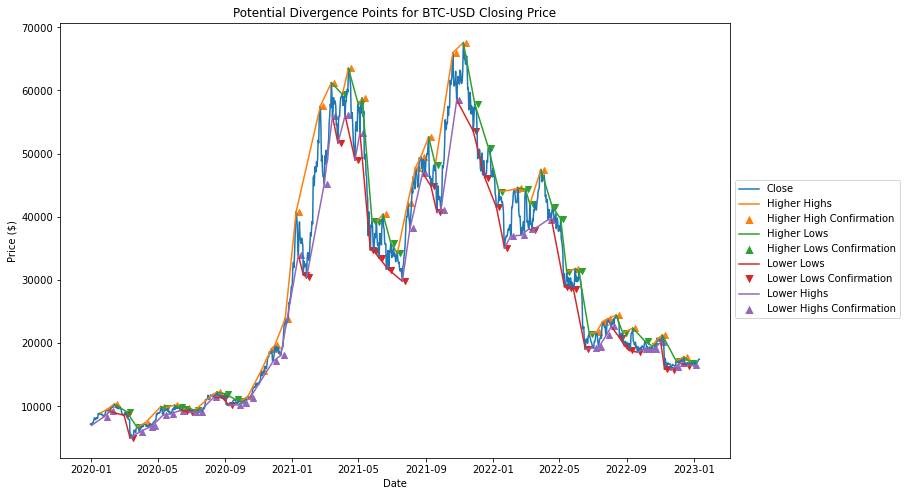

In [71]:
from matplotlib.lines import Line2D # For legend
price = data['Close'].values
dates = data.index
# Get higher highs, lower lows, etc.
order = 5
hh = getHigherHighs(price, order)
lh = getLowerHighs(price, order)
ll = getLowerLows(price, order)
hl = getHigherLows(price, order)
# Get confirmation indices
hh_idx = np.array([i[1] + order for i in hh])
lh_idx = np.array([i[1] + order for i in lh])
ll_idx = np.array([i[1] + order for i in ll])
hl_idx = np.array([i[1] + order for i in hl])
# Plot results
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(12, 8))
plt.plot(data['Close'])
plt.scatter(dates[hh_idx], price[hh_idx-order], marker='^', c=colors[1])
plt.scatter(dates[lh_idx], price[lh_idx-order], marker='v', c=colors[2])
plt.scatter(dates[ll_idx], price[ll_idx-order], marker='v', c=colors[3])
plt.scatter(dates[hl_idx], price[hl_idx-order], marker='^', c=colors[4])
_ = [plt.plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [plt.plot(dates[i], price[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], price[i], c=colors[4]) for i in hl]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.65))
plt.show()

The RSI is most frequently interpreted as showing upward momentum when the value is above the center line (RSI=50), and downward momentum when it is below the center line. If we have a series of smaller peaks above 50, it could indicate a reduction in momentum, and a series of increasing valleys below 50 could be a sign of increasing momentum that we could trade.

The next step for us then is to calculate the RSI, then apply the same technique as shown above to extract the relevant extrema. Code for the RSI is taken from this post if you’d like to get into the details and see some examples.

In [72]:
def calcRSI(data, P=14):
  data['diff_close'] = data['Close'] - data['Close'].shift(1)
  data['gain'] = np.where(data['diff_close']>0, data['diff_close'], 0)
  data['loss'] = np.where(data['diff_close']<0, np.abs(data['diff_close']), 0)
  data[['init_avg_gain', 'init_avg_loss']] = data[
    ['gain', 'loss']].rolling(P).mean()
  avg_gain = np.zeros(len(data))
  avg_loss = np.zeros(len(data))
  for i, _row in enumerate(data.iterrows()):
    row = _row[1]
    if i < P - 1:
      last_row = row.copy()
      continue
    elif i == P-1:
      avg_gain[i] += row['init_avg_gain']
      avg_loss[i] += row['init_avg_loss']
    else:
      avg_gain[i] += ((P - 1) * avg_gain[i-1] + row['gain']) / P
      avg_loss[i] += ((P - 1) * avg_loss[i-1] + row['loss']) / P
          
    last_row = row.copy()
      
  data['avg_gain'] = avg_gain
  data['avg_loss'] = avg_loss
  data['RS'] = data['avg_gain'] / data['avg_loss']
  data['RSI'] = 100 - 100 / (1 + data['RS'])
  return data

With that function in place, we can the RSI and its related columns to our data frame with:

In [73]:
data = calcRSI(data.copy())
rsi = data['RSI'].values
# Get values to mark RSI highs/lows and plot
rsi_hh = getHigherHighs(rsi, order)
rsi_lh = getLowerHighs(rsi, order)
rsi_ll = getLowerLows(rsi, order)
rsi_hl = getHigherLows(rsi, order)
# Get indices
rsi_hh_idx = getHHIndex(rsi, order)
rsi_lh_idx = getLHIndex(rsi, order)
rsi_ll_idx = getLLIndex(rsi, order)
rsi_hl_idx = getHLIndex(rsi, order)

We’ll follow the same format as above to plot our results:

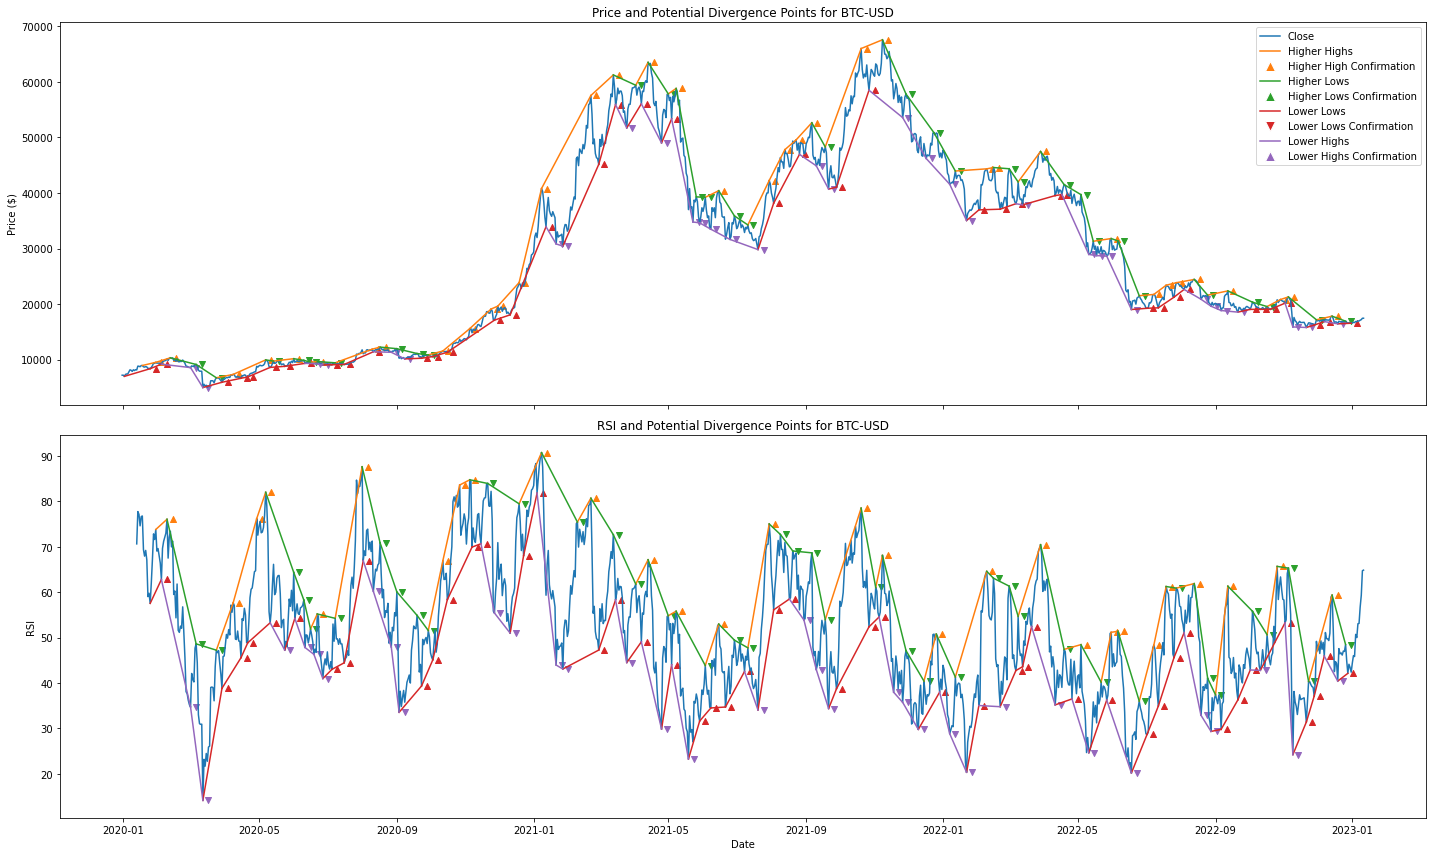

In [74]:
fig, ax = plt.subplots(2, figsize=(20, 12), sharex=True)
ax[0].plot(data['Close'])
ax[0].scatter(dates[hh_idx], price[hh_idx-order], 
              marker='^', c=colors[1])
ax[0].scatter(dates[lh_idx], price[lh_idx-order],
              marker='v', c=colors[2])
ax[0].scatter(dates[hl_idx], price[hl_idx-order],
              marker='^', c=colors[3])
ax[0].scatter(dates[ll_idx], price[ll_idx-order],
              marker='v', c=colors[4])
_ = [ax[0].plot(dates[i], price[i], c=colors[1]) for i in hh]
_ = [ax[0].plot(dates[i], price[i], c=colors[2]) for i in lh]
_ = [ax[0].plot(dates[i], price[i], c=colors[3]) for i in hl]
_ = [ax[0].plot(dates[i], price[i], c=colors[4]) for i in ll]
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'Price and Potential Divergence Points for {ticker}')
ax[0].legend(handles=legend_elements)
ax[1].plot(data['RSI'])
ax[1].scatter(dates[rsi_hh_idx], rsi[rsi_hh_idx-order], 
              marker='^', c=colors[1])
ax[1].scatter(dates[rsi_lh_idx], rsi[rsi_lh_idx-order],
              marker='v', c=colors[2])
ax[1].scatter(dates[rsi_hl_idx], rsi[rsi_hl_idx-order],
              marker='^', c=colors[3])
ax[1].scatter(dates[rsi_ll_idx], rsi[rsi_ll_idx-order],
              marker='v', c=colors[4])
_ = [ax[1].plot(dates[i], rsi[i], c=colors[1]) for i in rsi_hh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[2]) for i in rsi_lh]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[3]) for i in rsi_hl]
_ = [ax[1].plot(dates[i], rsi[i], c=colors[4]) for i in rsi_ll]
ax[1].set_ylabel('RSI')
ax[1].set_title(f'RSI and Potential Divergence Points for {ticker}')
ax[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

So far we have some general rules for identifying cases where we have divergences, but we still need entry and exit rules. For starters, we can turn to Kaufmann’s excellent Trading Systems and Methods where he lays out an example strategy with the following rules:

Enter a position when the divergence has been identified if the indicator is above the target level (e.g. RSI = 50).
Exit if the indicator divergence disappears. If we short while the price makes a higher high and the RSI makes a lower high, then our RSI moves to a higher high, then we’re out.
Exit once the indicator has reached the target level.
Allow the divergence to convert to a trend position. For this, we use a separate trend indicator (e.g. EMA cross-over) and we hold the position if the trend is in the same direction as the divergence. If the divergence disappears but the trend continues we hold, and exit only when the trend disappears.
We’re going to build two models off of Kaufmann’s rules, one that is only trading the divergences (rules 1–3) and one that has divergence plus trend (all 4 rules). Of course, feel free to modify these as you see fit and experiment with a variety of approaches yourself.

Next, I’m going to build some helper functions to mark our peaks. The first set are going to modify the output of our getHigherHighs group of functions. These were built for the vizualizations above, but we just need to extract the confirmation points of the trends for our model. Also note that because we're adding order to our index, we could get confirmation points that will raise index errors, so we drop any indices that are greater than the number of data points we have.

The four functions are below:

In [75]:
def getHHIndex(data: np.array, order=5, K=2):
  extrema = getHigherHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLHIndex(data: np.array, order=5, K=2):
  extrema = getLowerHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLLIndex(data: np.array, order=5, K=2):
  extrema = getLowerLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getHLIndex(data: np.array, order=5, K=2):
  extrema = getHigherLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

To reduce re-writing code, I’m going to introduce a function called getPeaks which takes our data frame and encodes the output of our highs and lows into column vectors. It will use the four functions we defined above and assign a value of 1 from the point we hit higher highs into the Close_highs column. If our highs are trending down after confirming a lower high, then we mark that with a -1 in the same column. It will do the same for the lows. It will be important to remember which values have a 1 and which have a -1, so I made it a 1 if the trend is increasing (higher highs or higher lows) and -1 if the trend is decreasing (lower highs or lower lows).

In [76]:
def getPeaks(data, key='Close', order=5, K=2):
  vals = data[key].values
  hh_idx = getHHIndex(vals, order, K)
  lh_idx = getLHIndex(vals, order, K)
  ll_idx = getLLIndex(vals, order, K)
  hl_idx = getHLIndex(vals, order, K)

  data[f'{key}_highs'] = np.nan
  data[f'{key}_highs'][hh_idx] = 1
  data[f'{key}_highs'][lh_idx] = -1
  data[f'{key}_highs'] = data[f'{key}_highs'].ffill().fillna(0)
  data[f'{key}_lows'] = np.nan
  data[f'{key}_lows'][ll_idx] = 1
  data[f'{key}_lows'][hl_idx] = -1
  data[f'{key}_lows'] = data[f'{key}_highs'].ffill().fillna(0)
  return data

Finally, we can build our strategy. Here, we’re just following the first 3 rules laid out above.

In [83]:
def RSIDivergenceStrategy(data, P=14, order=5, K=2):
  '''
  Go long/short on price and RSI divergence.
  - Long if price to lower low and RSI to higher low with RSI < 50
  - Short if price to higher high and RSI to lower high with RSI > 50
  Sell if divergence disappears.
  Sell if the RSI crosses the centerline.
  '''
  data = getPeaks(data, key='Close', order=order, K=K)
  data = calcRSI(data, P=P)
  data = getPeaks(data, key='RSI', order=order, K=K)

  position = np.zeros(data.shape[0])
  for i, (t, row) in enumerate(data.iterrows()):
    if np.isnan(row['RSI']):
      continue
    # If no position is on
    if position[i-1] == 0:
      # Buy if indicator to higher low and price to lower low
      if row['Close_lows'] == -1 and row['RSI_lows'] == 1:
        if row['RSI'] < 50:
          position[i] = 1
          entry_rsi = row['RSI'].copy()

      # Short if price to higher high and indicator to lower high
      elif row['Close_highs'] == 1 and row['RSI_highs'] == -1:
        if row['RSI'] > 50:
          position[i] = -1
          entry_rsi = row['RSI'].copy()

    # If current position is long
    elif position[i-1] == 1:
      if row['RSI'] < 50 and row['RSI'] < entry_rsi:
        position[i] = 1
  
    # If current position is short
    elif position[i-1] == -1:
      if row['RSI'] < 50 and row['RSI'] > entry_rsi:
        position[i] = -1

  data['position'] = position
  return calcReturns(data)

def calcReturns(df):
  # Helper function to avoid repeating too much code
  df['returns'] = df['Close'] / df['Close'].shift(1)
  df['log_returns'] = np.log(df['returns'])
  df['strat_returns'] = df['position'].shift(1) * df['returns']
  df['strat_log_returns'] = df['position'].shift(1) * df['log_returns']
  df['cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1
  df['strat_cum_returns'] = np.exp(df['strat_log_returns'].cumsum()) - 1
  df['peak'] = df['cum_returns'].cummax()
  df['strat_peak'] = df['strat_cum_returns'].cummax()
  return df

One thing to note on the exit conditions, we’re to wait for a change in the trend. Rather than waiting for 5 days for a confirmation from a peak in the RSI, I added a condition that states if the RSI breaks below our entry RSI on a long position or above our entry RSI on a short position, we should get out. This works because if we short on a lower high in the RSI, then we’re going to exit if that reverses. If the RSI closes above our entry RSI, then either that becomes a higher high, thereby breaking our trend, or a higher high will still come. Putting this condition in just gets us out of the trade much more quickly.

In [84]:
def getStratStats(log_returns: pd.Series,
  risk_free_rate: float = 0.02):
  stats = {}  # Total Returns
  stats['tot_returns'] = np.exp(log_returns.sum()) - 1 
   
  # Mean Annual Returns
  stats['annual_returns'] = np.exp(log_returns.mean() * 252) - 1 
   
  # Annual Volatility
  stats['annual_volatility'] = log_returns.std() * np.sqrt(252)
   
  # Sortino Ratio
  annualized_downside = log_returns.loc[log_returns<0].std() * \
    np.sqrt(252)
  stats['sortino_ratio'] = (stats['annual_returns'] - \
    risk_free_rate) / annualized_downside  
   
  # Sharpe Ratio
  stats['sharpe_ratio'] = (stats['annual_returns'] - \
    risk_free_rate) / stats['annual_volatility']  
   
  # Max Drawdown
  cum_returns = log_returns.cumsum() - 1
  peak = cum_returns.cummax()
  drawdown = peak - cum_returns
  max_idx = drawdown.argmax()
  stats['max_drawdown'] = 1 - np.exp(cum_returns[max_idx]) \
    / np.exp(peak[max_idx])
   
  # Max Drawdown Duration
  strat_dd = drawdown[drawdown==0]
  strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
  strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
  strat_dd_days = np.hstack([strat_dd_days,
    (drawdown.index[-1] - strat_dd.index[-1]).days])
  stats['max_drawdown_duration'] = strat_dd_days.max()
  return {k: np.round(v, 4) if type(v) == np.float_ else v
          for k, v in stats.items()}

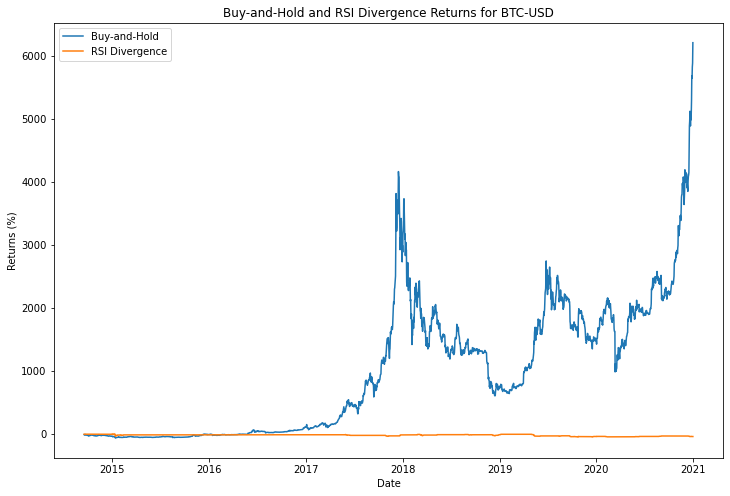

,tot_returns,annual_returns,annual_volatility,sortino_ratio,sharpe_ratio,max_drawdown,max_drawdown_duration
Buy and Hold,62.0632,0.5759,0.6166,1.0646,0.9017,0.8340,1080
Divergence,-0.3717,-0.0497,0.2168,-0.1294,-0.3217,0.4701,2181


In [85]:
start = '2000-01-01'
end = '2020-12-31'
data = yfObj.history(start=start, end=end)
# Drop unused columns
data.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 
  'Stock Splits'], axis=1, inplace=True)

df_div = RSIDivergenceStrategy(data.copy())

plt.figure(figsize=(12, 8))
plt.plot(df_div['cum_returns'] * 100, label='Buy-and-Hold')
plt.plot(df_div['strat_cum_returns'] * 100, label='RSI Divergence')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.title(f'Buy-and-Hold and RSI Divergence Returns for {ticker}')
plt.legend()
plt.show()
df_stats = pd.DataFrame(getStratStats(df_div['log_returns']), 
                        index=['Buy and Hold'])
df_stats = pd.concat([df_stats, 
                      pd.DataFrame(getStratStats(df_div['strat_log_returns']),
                                   index=['Divergence'])])
df_stats

# RSI Divergence and Trend

For this next model, let’s take Kaufman’s suggestion and apply a trend conversion. For this, we’re going to choose an EMA cross-over. So, the model will trade just like the divergence model we saw above, but will check the trend as indicated by our EMA cross-over. If we’re long and EMA1 > EMA2, we keep that position going.

Code for the EMA calculation and the strategy are given below:

In [86]:
def _calcEMA(P, last_ema, N):
  return (P - last_ema) * (2 / (N + 1)) + last_ema

def calcEMA(data, N):
  # Initialize series
  data['SMA_' + str(N)] = data['Close'].rolling(N).mean()
  ema = np.zeros(len(data))
  for i, _row in enumerate(data.iterrows()):
    row = _row[1]
    if i < N:
      ema[i] += row['SMA_' + str(N)]
    else:
      ema[i] += _calcEMA(row['Close'], ema[i-1], N)
  data['EMA_' + str(N)] = ema.copy()
  return data

def RSIDivergenceWithTrendStrategy(data, P=14, order=5, K=2, EMA1=50, EMA2=200):
  '''
  Go long/short on price and RSI divergence.
  - Long if price to lower low and RSI to higher low with RSI < 50
  - Short if price to higher high and RSI to lower high with RSI > 50
  Sell if divergence disappears or if the RSI crosses the centerline, unless
  there is a trend in the same direction.
  '''
  data = getPeaks(data, key='Close', order=order, K=K)
  data = calcRSI(data, P=P)
  data = getPeaks(data, key='RSI', order=order, K=K)
  data = calcEMA(data, EMA1)
  data = calcEMA(data, EMA2)
  position = np.zeros(data.shape[0])
  
  for i, (t, row) in enumerate(data.iterrows()):
    if np.isnan(row['RSI']):
      continue
    # If no position is on
    if position[i-1] == 0:
      # Buy if indicator to higher high and price to lower high
      if row['Close_lows'] == -1 and row['RSI_lows'] == 1:
        if row['RSI'] < 50:
          position[i] = 1
          entry_rsi = row['RSI'].copy()

      # Short if price to higher high and indicator to lower high
      elif row['Close_highs'] == 1 and row['RSI_highs'] == -1:
        if row['RSI'] > 50:
          position[i] = -1
          entry_rsi = row['RSI'].copy()

    # If current position is long
    elif position[i-1] == 1:
      if row['RSI'] < 50 and row['RSI'] < entry_rsi:
        position[i] = 1
      elif row[f'EMA_{EMA1}'] > row[f'EMA_{EMA2}']:
        position[i] = 1
  
    # If current position is short
    elif position[i-1] == -1:
      if row['RSI'] < 50 and row['RSI'] > entry_rsi:
        position[i] = -1
      elif row[f'EMA_{EMA1}'] < row[f'EMA_{EMA2}']:
        position[i] = -1

  data['position'] = position

  return calcReturns(data)

Running this model on our data we get:

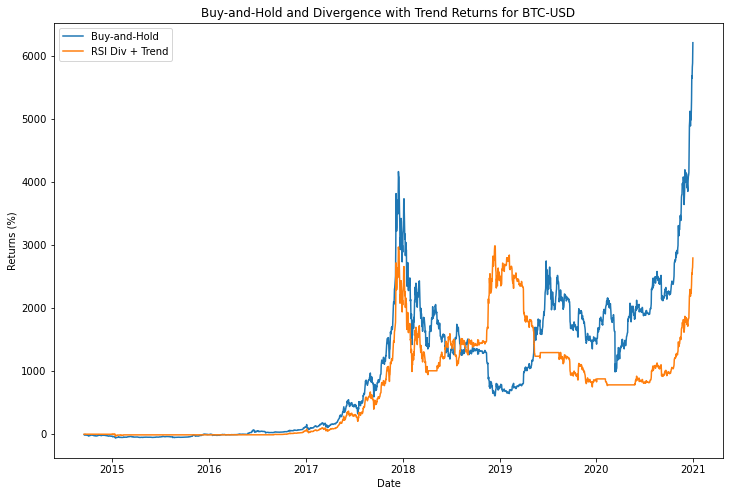

,tot_returns,annual_returns,annual_volatility,sortino_ratio,sharpe_ratio,max_drawdown,max_drawdown_duration
Buy and Hold,62.0632,0.5759,0.6166,1.0646,0.9017,0.8340,1080
Divergence,-0.3717,-0.0497,0.2168,-0.1294,-0.3217,0.4701,2181
Div + Trend,27.9270,0.4467,0.4822,0.8582,0.8850,0.7249,746


In [88]:
df_trend = RSIDivergenceWithTrendStrategy(data.copy())
plt.figure(figsize=(12, 8))
plt.plot(df_trend['cum_returns'] * 100, label=f'Buy-and-Hold')
plt.plot(df_trend['strat_cum_returns'] * 100, label='RSI Div + Trend')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.title(f'Buy-and-Hold and Divergence with Trend Returns for {ticker}')
plt.legend()
plt.show()

df_stats = pd.concat([df_stats, 
                      pd.DataFrame(getStratStats(df_trend['strat_log_returns']), 
                                   index=['Div + Trend'])])
df_stats

We looked at coding and trading two RSI divergence strategies, one was great and the other wasn’t. Does this mean you should go out and trade the RSI divergence with an EMA cross-over?

No.

500% returns look great, but keep in mind that we did this on a single instrument, without money or risk management principles, just with the basic settings, in a vectorized backtest that doesn’t account for transaction costs or dividends, and with free data that may or may not be reliable.

This is here to give you some ideas and explanation about these indicators. These quick and dirty backtests are useful because you get a feel for how to test ideas and can go out and test it on a variety of securities and markets to begin to narrow down your options. Maybe a more rigorous test shows the RSI divergence is a really valuable part of your system and the trend model is an outlier. You’ll never know unless you test it!